# 🙂[Exploration_03] 인물 모드 문제점 찾기
<BR>  
    <BR>  
        <BR>  

In [21]:
# importlib: 사용자가 파이썬의 import 시스템과 상호작용하기 위한 API를 제공하는 내장 라이브러리
# 사용자는 import 함수의 구현 내용과, 실행에 필요한 하위 함수들을 이용해 필요에 맞는 임포터를 직접 구현하거나 임포트 관련 기능들을 자유롭게 사용할 수 있음
# importlib.metadata: 설치된 패키지 메타 데이터에 대한 접근을 제공하는 라이브러리.
# 해당 코드 블럭에서는 importlib.metadata 안에 있는 version() 함수를 이용하여 pixellib 라이브러리의 버전을 확인

from importlib.metadata import version
import cv2
import pixellib
import os
import urllib
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

print(cv2.__version__)
print(version('pixellib'))

4.5.3
0.7.1


## 🤖Step 1. 인물모드 직접 해 보기

In [22]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/selfie11.jpeg'
img_orig = cv2.imread(img_path)

print(img_orig.shape)

(960, 1440, 3)


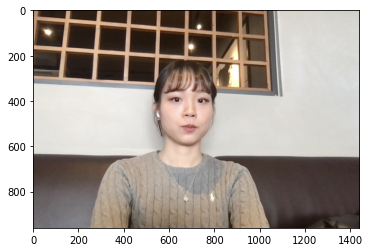

In [23]:
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 이미지 색상 채널을 변경 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [24]:
# 저장할 파일의 이름을 결정하자.
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
# 2
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url이다.
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# 다운로드를 시작한다.
# urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장
urllib.request.urlretrieve(model_url, model_file) 

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f0ffb7371c0>)

In [25]:
# 우리가 사용할 세그멘테이션 모델 생성하기
model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

In [26]:
# 이미지 입력하기
segvalues, output = model.segmentAsPascalvoc(img_path) # segmentAsPascalvoc()함 수 를 호출 하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 분할 은 pacalvoc 데이터로 학습된 모델을 이용

In [27]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)


21

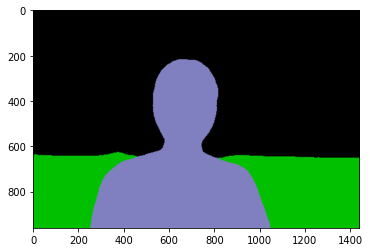

In [28]:
#segmentAsPascalvoc() 함수 를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력
plt.imshow(output)
plt.show()


In [29]:
#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person
sofa


In [30]:
# PixelLib에서 그대로 가져온 코드이다.
# 주목해야 할 것은 생상 코드 결과물!

#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [31]:
# 사람을 나타내는 15번째 색상은 무엇인가?
colormap[15]

array([192, 128, 128])

In [32]:
seg_color = (128,128,192) # 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서

<br>  

---


**seg_color로만 이루어진 마스크를 만들어보자**

(960, 1440)


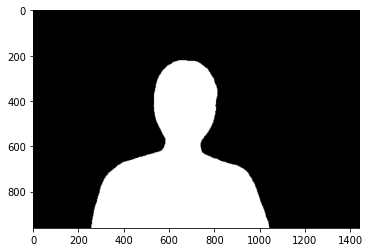

In [33]:
# seg_color로만 이루어진 마스크를 만들어보자

# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
# seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()


**원본은 3채널을 가졌었는데, 지금은 채널 정보가 사라졌다!**

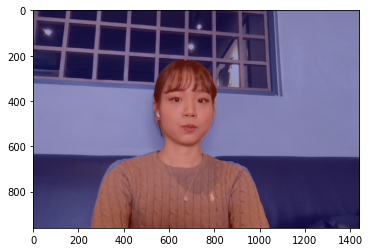

In [34]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()


<br>  

---


## 🔶배경 흐리게 만들기  
- blur() 함수를 활용해보자!

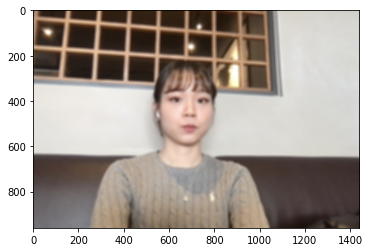

In [35]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13,13))

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)   
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

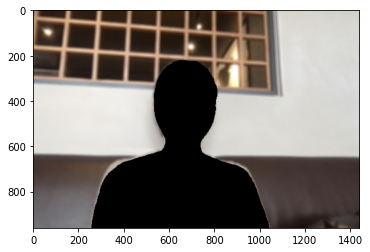

In [36]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출하기

# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

---

`bitwise_not` 함수를 이용하면 이미지가 반전됩니다. 원래 마스크에서는 배경이 0, 사람이 255였으니  
`bitwise_not` 연산을 하고 나면 배경은 255, 사람은 0이 될 것 같다.    

<br>  

반전된 세그멘테이션 결과를 이용해서 이미지와 `bitwise_and` 연산을 수행하면 배경만 있는 영상을 얻을 수 있다. 0과 어떤 수를 `bitwise_and` 연산을 해도 0이 되기 때문에 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 된다. 결국 사람이 사라지게 되는 것이다.

<br>  

---

## 🔶흐린 배경과 원본 영상 합성하기

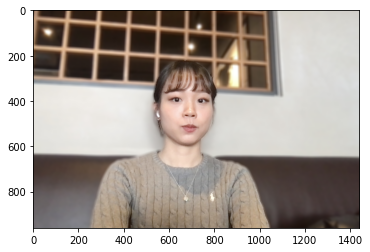

In [37]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

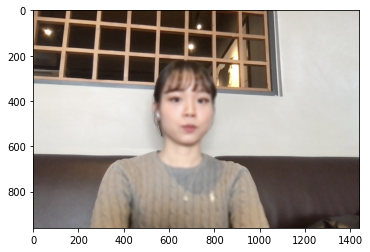

In [38]:
# 반대로 사람 부분을 블러로, 배경 부분을 원본으로 출력
img_concat = np.where(img_mask_color == 255, img_orig_blur, img_orig )
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()


---

## 🔶강아지 사진에 대한 아웃포커싱 사진도 만들어보자!

(3024, 4032, 3)


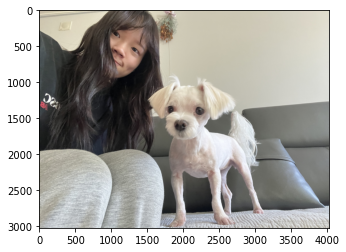

In [65]:
# 강아지 사진에 대한 아웃포커싱 사진도 만들어보자!

img_path2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/dogwithme.jpg'
img_orig2 = cv2.imread(img_path2)

print(img_orig2.shape)

plt.imshow(cv2.cvtColor(img_orig2, cv2.COLOR_BGR2RGB))
plt.show()

In [48]:
import cv2

# 이미지를 읽어오기
image = cv2.imread(img_path2)
# 이미지를 960x1440 크기로 리사이즈
resized_image = cv2.resize(image, (1440, 960))

# 리사이즈된 이미지를 파일로 저장 (선택사항)
cv2.imwrite('resized_dogwithme2.jpg', resized_image)
print(resized_image.shape)

(960, 1440, 3)


In [49]:
img_path3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/resized_dogwithme2.jpg'
img_orig3 = cv2.imread(img_path3)

In [66]:
# 우리가 사용할 세그멘테이션 모델 생성
model = semantic_segmentation() 
model.load_pascalvoc_model(model_file)

In [67]:
# 이미지 입력하기
segvalues, output = model.segmentAsPascalvoc(img_path3)

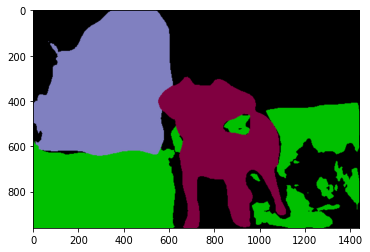

In [68]:
plt.imshow(output)
plt.show()

In [70]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
dog
person
sofa


In [73]:
# 강아지를 나타내는 12번째 색상
colormap[12]

array([ 64,   0, 128])

In [74]:
# # 색상순서 변경
seg_color3 = (128,0,64)

(960, 1440)


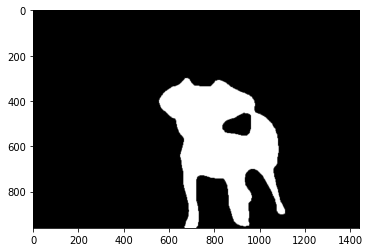

In [75]:
# seg_color로만 이루어진 강아지 마스크를 만들어보자
seg_map3 = np.all(output==seg_color3, axis=-1) 
print(seg_map3.shape) 
plt.imshow(seg_map3, cmap='gray')
plt.show()

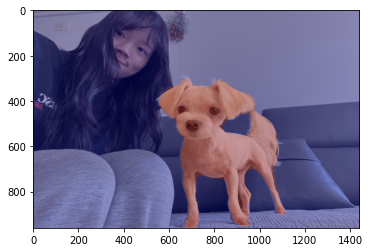

In [78]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show3 = img_orig3.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask3 = seg_map3.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask3 = cv2.applyColorMap(img_mask3, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show3 = cv2.addWeighted(img_show3, 0.6, color_mask3, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show3, cv2.COLOR_BGR2RGB))
plt.show()

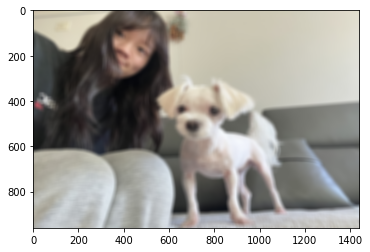

In [79]:
# (20,20)은 blurring kernel size를 뜻한다

img_orig_blur3 = cv2.blur(img_orig3, (20,20))
  
plt.imshow(cv2.cvtColor(img_orig_blur3, cv2.COLOR_BGR2RGB))
plt.show()

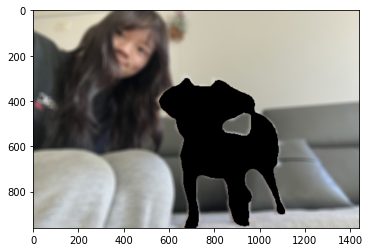

In [82]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출하기
img_mask_color3 = cv2.cvtColor(img_mask3, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전
img_bg_mask3 = cv2.bitwise_not(img_mask_color3)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
img_bg_blur3 = cv2.bitwise_and(img_orig_blur3, img_bg_mask3)
plt.imshow(cv2.cvtColor(img_bg_blur3, cv2.COLOR_BGR2RGB))
plt.show()

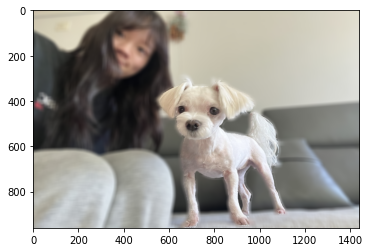

In [86]:
img_concat3 = np.where(img_mask_color3==255, img_orig3, img_bg_blur3)

plt.imshow(cv2.cvtColor(img_concat3, cv2.COLOR_BGR2RGB))
plt.show()

---

## 🔶배경사진을 다른 이미지로 교체하는 크로마키 배경 합성을 시도해보자!

(720, 1280, 3)


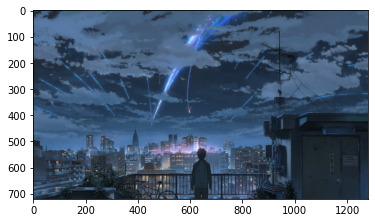

In [88]:
img_path4 = os.getenv('HOME')+'/aiffel/human_segmentation/images/sinkai.jpg'
img_orig4 = cv2.imread(img_path4)

print(img_orig4.shape)

plt.imshow(cv2.cvtColor(img_orig4, cv2.COLOR_BGR2RGB))
plt.show()

In [89]:
# 이미지를 읽어오기
image = cv2.imread(img_path4)
# 이미지를 960x1440 크기로 리사이즈
resized_image = cv2.resize(image, (1440, 960))

# 리사이즈된 이미지를 파일로 저장 (선택사항)
cv2.imwrite('resized_sinkai.jpg', resized_image)
print(resized_image.shape)

(960, 1440, 3)


In [92]:
img_path4 = os.getenv('HOME')+'/aiffel/human_segmentation/images/resized_sinkai.jpg'
img_orig4 = cv2.imread(img_path4)

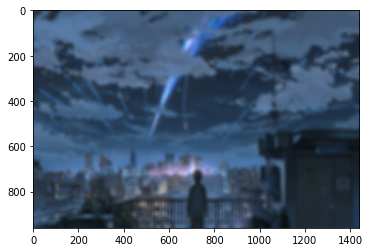

In [103]:
img_orig_blur4 = cv2.blur(img_orig4, (20,20))
  
plt.imshow(cv2.cvtColor(img_orig_blur4, cv2.COLOR_BGR2RGB))
plt.show()

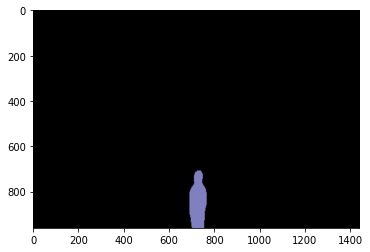

In [104]:
# 우리가 사용할 세그멘테이션 모델 생성
model = semantic_segmentation() 
model.load_pascalvoc_model(model_file)

# 이미지 입력하기
segvalues, output = model.segmentAsPascalvoc(img_path4)

plt.imshow(output)
plt.show()

(960, 1440)


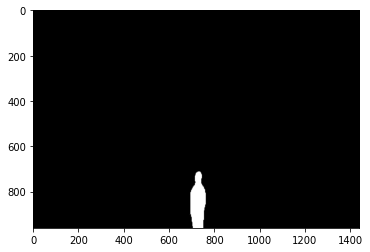

In [108]:
# 강아지를 나타내는 12번째 색상
colormap[15]

# # 색상순서 변경
seg_color4 = (128,128,192)

# seg_color로만 이루어진 강아지 마스크를 만들어보자
seg_map4 = np.all(output==seg_color4, axis=-1) 
print(seg_map4.shape) 
plt.imshow(seg_map4, cmap='gray')
plt.show()

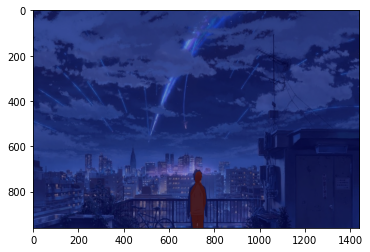

In [109]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show4 = img_orig4.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask4 = seg_map4.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask4 = cv2.applyColorMap(img_mask4, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show4 = cv2.addWeighted(img_show4, 0.6, color_mask4, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show4, cv2.COLOR_BGR2RGB))
plt.show()

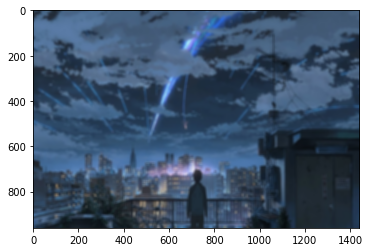

In [110]:
# blur() 함수를 사용
img_orig_blur4 = cv2.blur(img_orig4, (13,13))
 
plt.imshow(cv2.cvtColor(img_orig_blur4, cv2.COLOR_BGR2RGB))
plt.show()

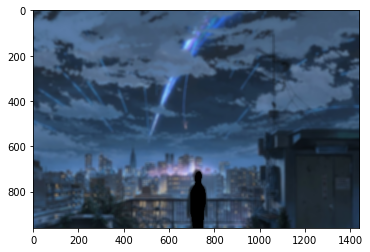

In [112]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출하기

img_mask_color4 = cv2.cvtColor(img_mask4, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask4 = cv2.bitwise_not(img_mask_color4)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur4 = cv2.bitwise_and(img_orig_blur4, img_bg_mask4)
plt.imshow(cv2.cvtColor(img_bg_blur4, cv2.COLOR_BGR2RGB))
plt.show()

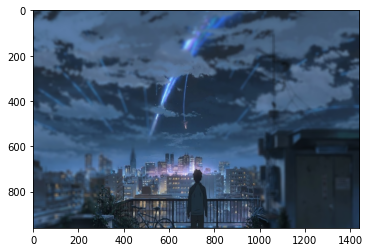

In [115]:
# 배경 영상과 사람 영상합치기

img_concat4 = np.where(img_mask_color==255, img_orig4, img_bg_blur4)

plt.imshow(cv2.cvtColor(img_concat4, cv2.COLOR_BGR2RGB))
plt.show()

### 🔶처음 인물모드 사진을 시도했던 셀피와 배경사진을 합성해보자!

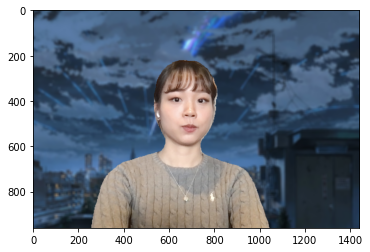

In [113]:
# 셀피와 배경사진을 합성해보자!

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur4)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

---
<BR>  
    <BR>  
        <BR>  

            

## 🤖Step 2. 사진에서 문제점 찾기

- 사람의 형태가 뚜렷하게 구분되지 않았다.
- 비교적 얇은 부분인 팔이 배경으로 포함되었다.

    

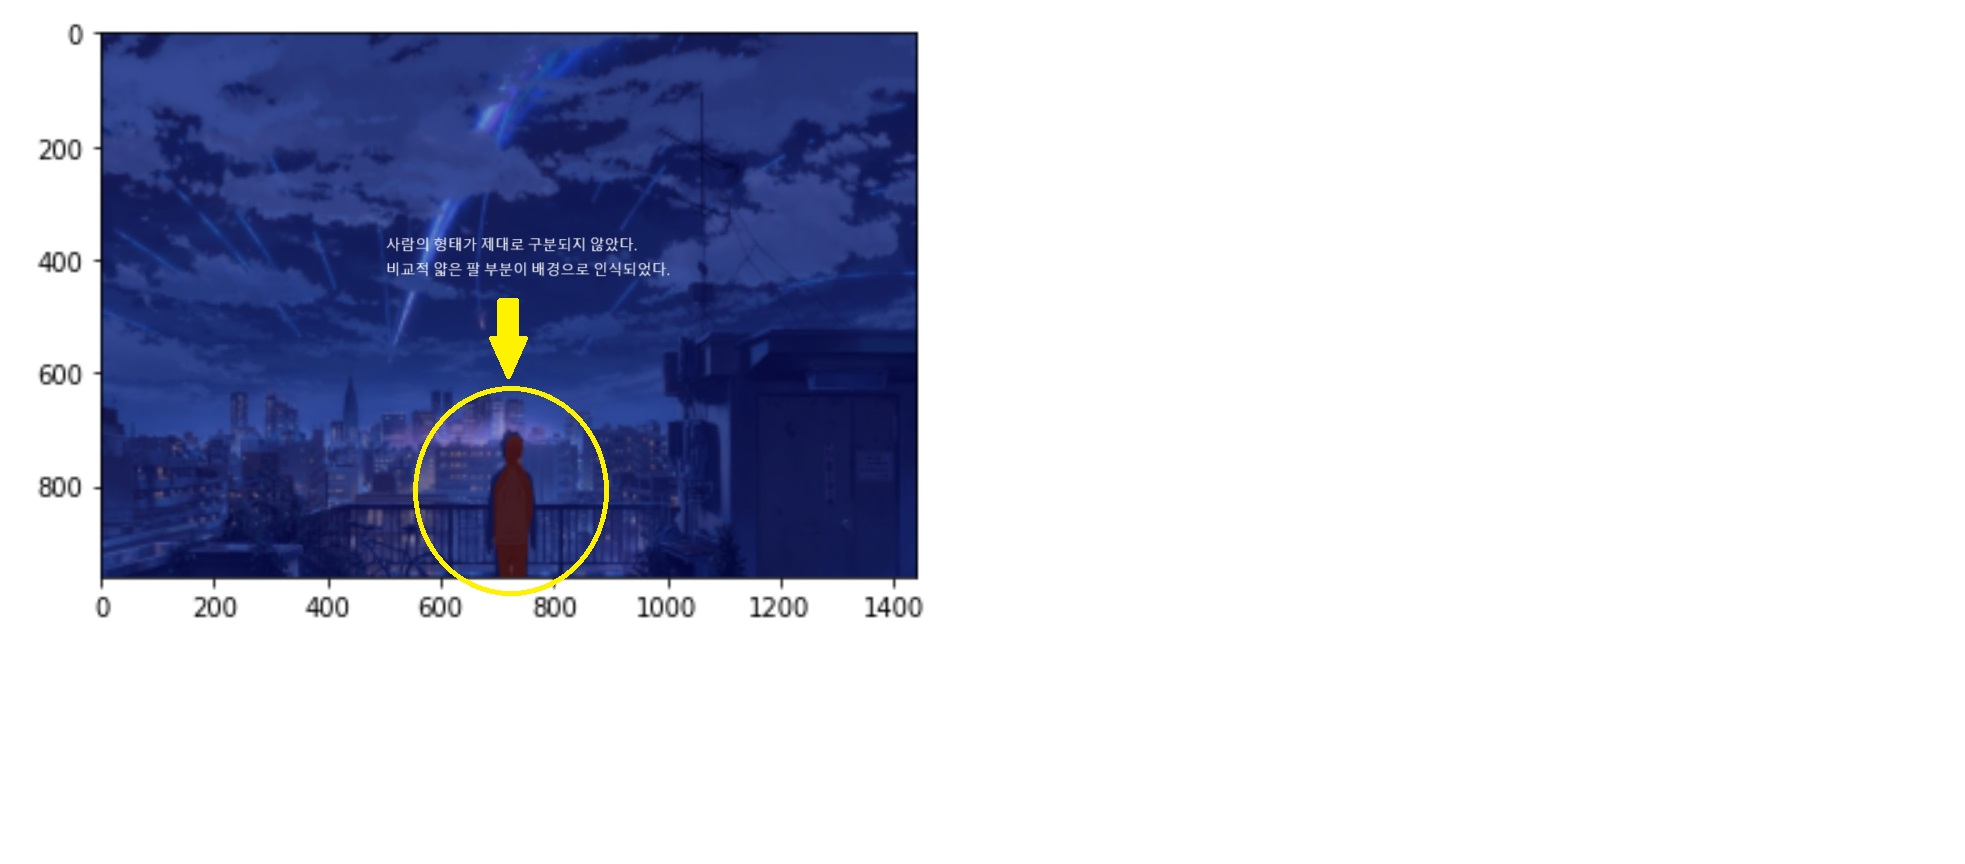


---

## 🤖Step 3. 해결 방법을 제안해 보기

내가 선택한 기술이 `DeepLab` 모델의 `Semantic Segmentation` 이 만들어 낸 Mask 영역에 어떻게 적용되어 문제점을 보완하게 되는지의 메커니즘이 포함된 솔루션을 제시해보자.  

인물모드 사진의 주요 문제점 중 하나는 `Semantic Segmentation` 모델의 부정확성으로 인한 오류이다. 이를 개선하기 위해 여러 솔루션을 적용할 수 있다.

<br>


- **다중 모델 활용하기**:    
    단일 모델의 한계를 극복하기 위해 다양한 `segmentation` 모델을 앙상블하여 사용할 수 있다.  
    
    `U-Net`는 고해상도 및 공간적인 상세 정보를 강조하며, 입력 이미지의 특정 부분을 잘 캡처하여 객체의 윤곽을 명확하게 보존하는 모델이고,   
    `FCN`는 공간적인 구조를 보존하면서 입력 이미지를 처리하므로, 더 큰 문맥을 고려하여 이미지의 전반적인 의미를 이해하고 객체의 일반적인 특징을 강조하는 모델이다.  
    
    예를 들어 위에 각 모델이 서로 다른 특징을 잡아낼 테니, 앙상블을 통해 전체적인 성능을 향상시킬 수 있을 것 같다.    
    `U-Net`, 및 `FCN`(Fully Convolutional Network)과 같은 서로 다른 구조의 모델들을 사용하면, 각 모델은 이미지의 다른 측면을 강조하기 때문에 문제점을 보완할 수 있을 것이라고 생각한다.  
    
<br>  

- **확장된 데이터셋과 데이터 증강 활용:**  
    모델이 다양한 상황에서 더 강건하게 작동하도록 하기 위해 풍부한 데이터셋이 필요하다.    
    
    데이터 증강은 제한된 데이터셋에서도 더 많은 다양성을 확보할 수 있는 방법 중 하나이다.  
    다양한 데이터셋으로부터 얻은 `Semantic Segmentation` 마스크를 사용하여 `Domain Adaptation` 기술(한 도메인에서 학습된 모델을 다른 도메인에서의 성능을 향상시키기 위한 기술)을 적용할 수 있다. 
    학습 데이터셋과 테스트 데이터셋 간의 도메인 차이를 줄이기 위해 `Transfer Learning`이나 `Fine-tuning`을 수행하여 모델을 특정 환경에 더 적응시킬 수 있다.  
    
     학습 데이터셋을 더 다양하게 구성하고, 데이터 증강 기술을 활용하여 모델의 일반화 성능을 향상시켜도 좋을 것 같다.  
<br>  
     

<br>  

- **자가 지도 학습(Self-Supervised Learning):**  
    `Semantic segmentation` 모델이 오류를 범하지 않도록 하기 위해, 모델이 스스로 지도를 생성하고 학습하는 방법을 도입해볼 수 있다.  
    이미지 내에서 부분적으로 가려진 영역을 복원하도록 모델이 학습하는 방식으로 진행하여 모델이 이미지 내에 라벨이 필요한 영역을 스스로 예측하고 이를 지도로 사용해서 손실을 계산하고 최적화를 수행하는 것이다.  
    자가 지도 학습 알고리즘을 활용하여 모델이 label되지 않은 데이터를 활용하여 스스로 학습하고 지속적으로 업데이트 할 수 있도록 할 수 있을 것 같다.  
    
<br>  
    
- **실시간 업데이트 및 딥러닝 기술 적용:**  
    `Semantic Segmentation` 모델을 실시간으로 업데이트하고, 최신 딥러닝 기술을 도입하여 모델의 성능을 지속적으로 개선해야하는 결론에 다다르는 것 같다..😂
    
    
---

## ⛓️회고  
<br>  
<br>  


#### - **Keep**  
    tutorial 노드를 적극 활용하였다. 구글링을 열심히 해보았다.
    
<br>  

#### - **Problem**  
    한번 정한 변수이름 뒤에 숫자만 붙여가며 사용했다. 모델이 조금 더 복잡해지면 많이 헷갈릴 것 같다.   
    좀 더 알아보기 쉽고 간단한 변수를 사용하는 습관을 들여야 될 것 같다.  
    
    
<br>  


#### - **Try**  
    코드를 조금 더 간결하고 간단하게 짜보기! 불필요한 코드도 많은 것 같다..군더더기 없는 코드를 짜보고 싶다..😀💧